https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series#3.-Time-series-decomposition-and-Random-walks

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("data_ver2/target_v2.csv")

### 3.1. Trends, seasonality and noise
These are the components of a time series

- Trend - Consistent upwards or downwards slope of a time series
- Seasonality - Clear periodic pattern of a time series(like sine funtion)
- Noise - Outliers or missing values

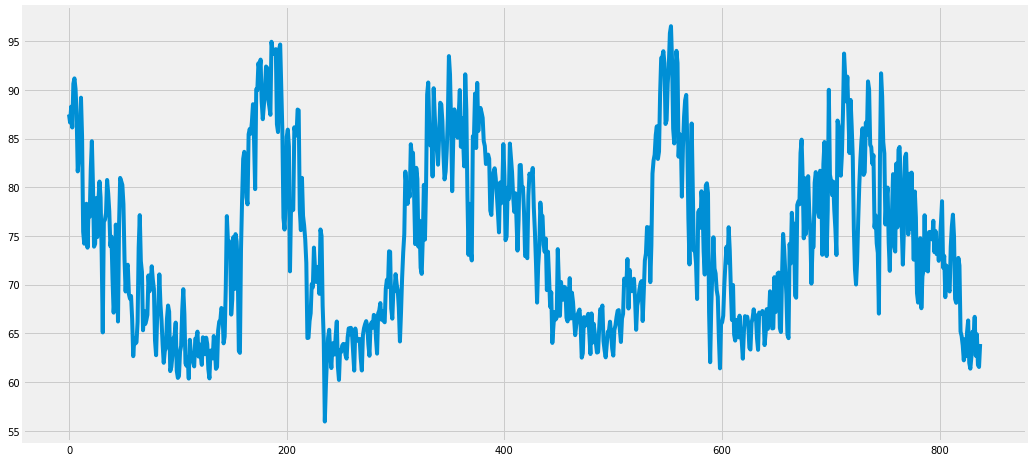

In [3]:
data.supply.plot(figsize=(16,8))

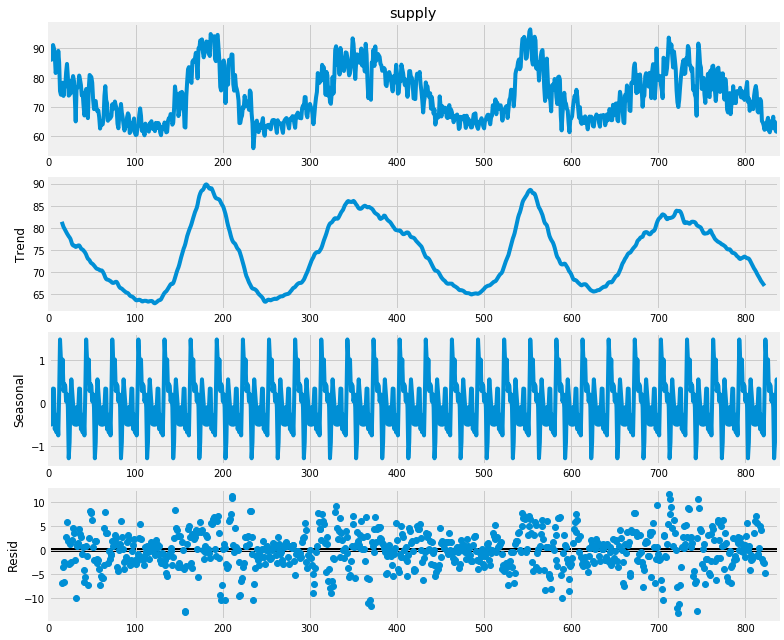

In [4]:
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(data.supply,freq=30) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

### White noise
White noise has...

- Constant mean
- Constant variance
- Zero auto-correlation at all lags

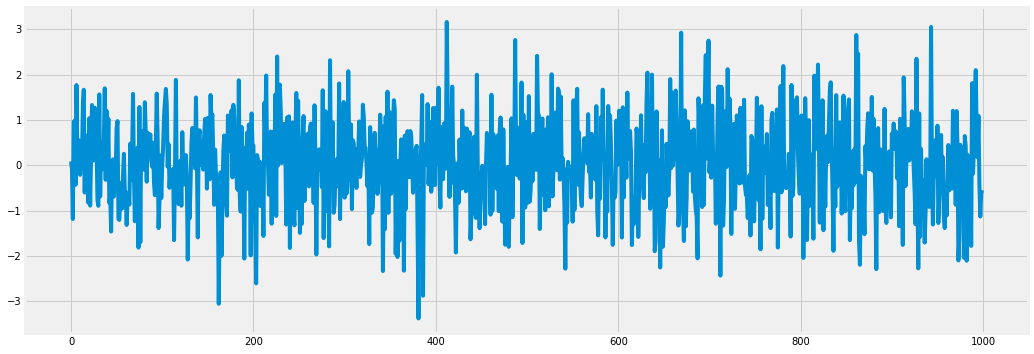

In [5]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

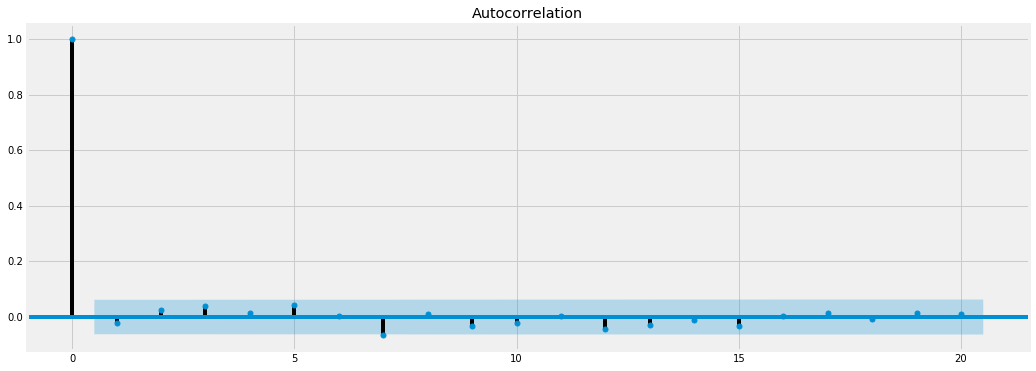

In [6]:
# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

See how all lags are statistically insigficant as they lie inside the confidence interval(shaded portion).

### Random Walk
A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

#### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [7]:
# Augmented Dickey-Fuller test on supply and smp_max
adf = adfuller(data.supply)
print("p-value of sypply: {}".format(float(adf[1])))
adf = adfuller(data.smp_max)
print("p-value of smp_max: {}".format(float(adf[1])))

p-value of sypply: 0.020935222609938943
p-value of smp_max: 0.02331752774950228


If p-value is less than 0.05, null hypothesis is rejected and this is not a random walk.

If p-value is more than 0.05, this is a random walk.

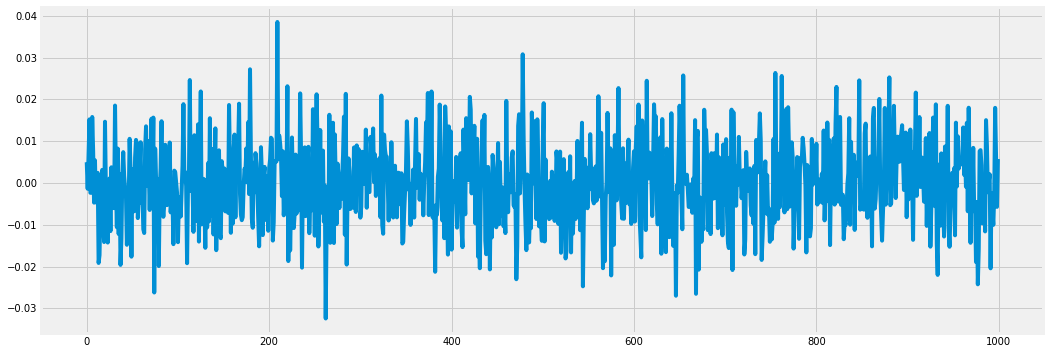

In [8]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [9]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

### Stationarity¶
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

- Strong stationarity: is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
- Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time.

Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

We will try to decompose seasonal component of the above decomposed time series.

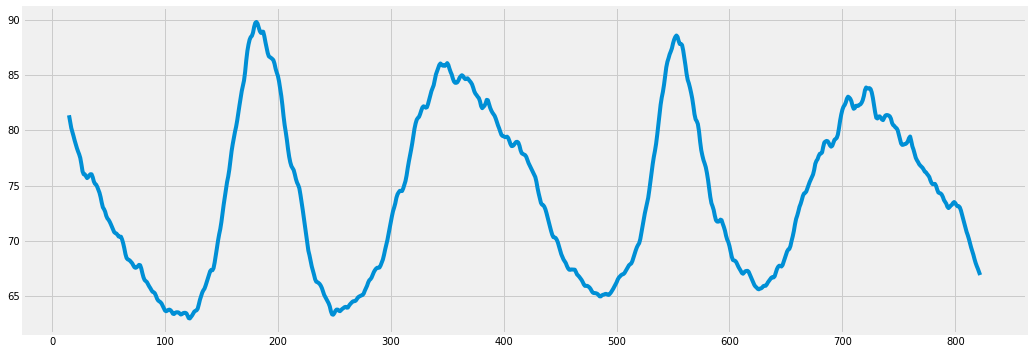

In [10]:
# The original non-stationary plot
decomposed_google_volume.trend.plot()

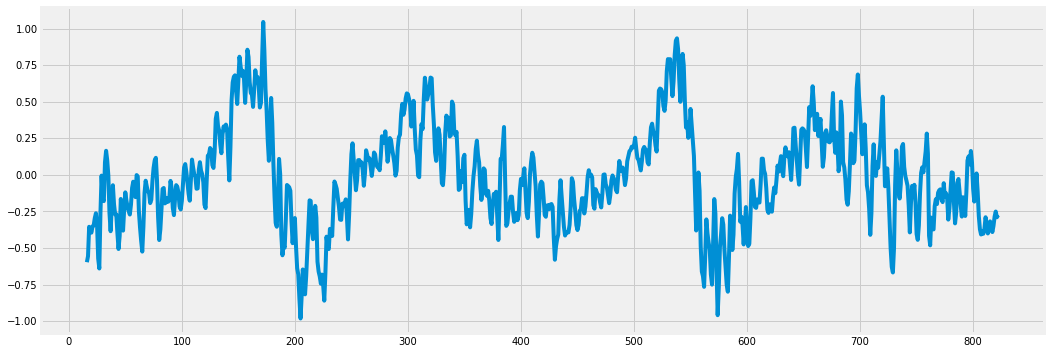

In [11]:
# The new stationary plot
decomposed_google_volume.trend.diff().plot()

###  Modelling using statstools¶
#### AR models
An autoregressive (AR) model is a representation of a type of random process; as such, it is used to describe certain time-varying processes in nature, economics, etc. The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term); thus the model is in the form of a stochastic difference equation.

### Simulating AR(1) model

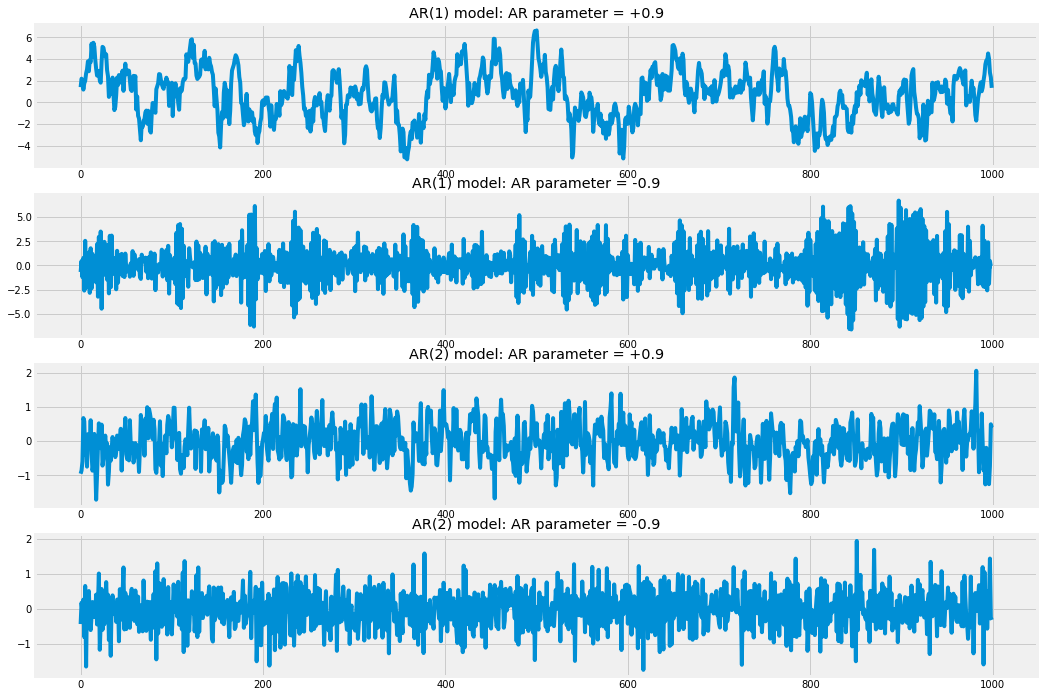

In [12]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()


### Forecasting a simulated model

In [13]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Tue, 19 May 2020   AIC                           2837.403
Time:                        18:34:32   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

### Predicting the models

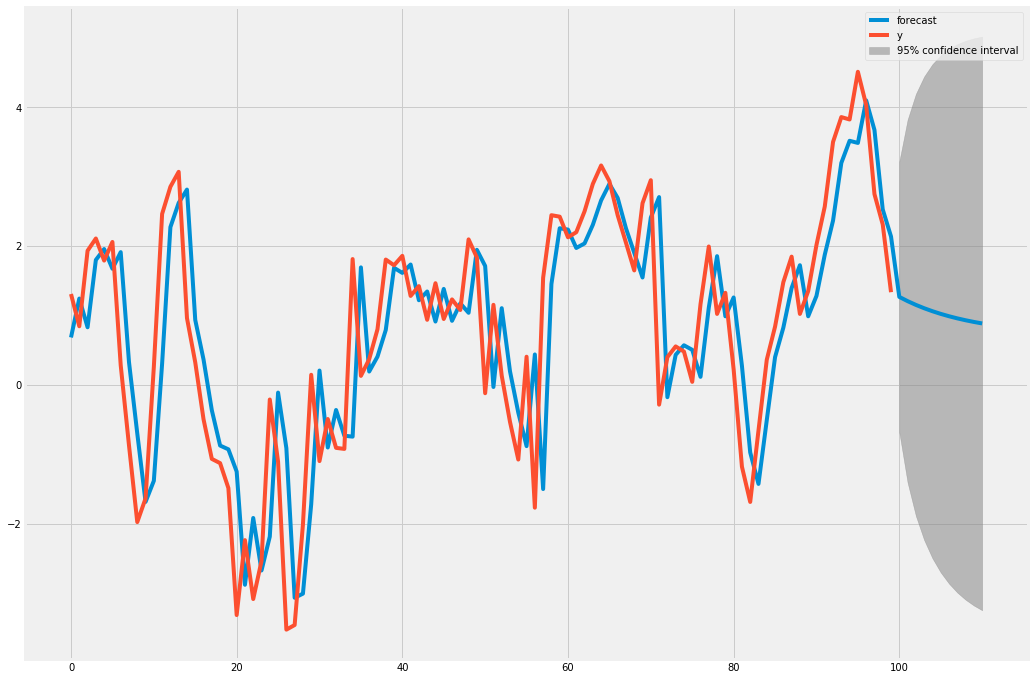

In [14]:
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
plt.show()

In [15]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054512080593.


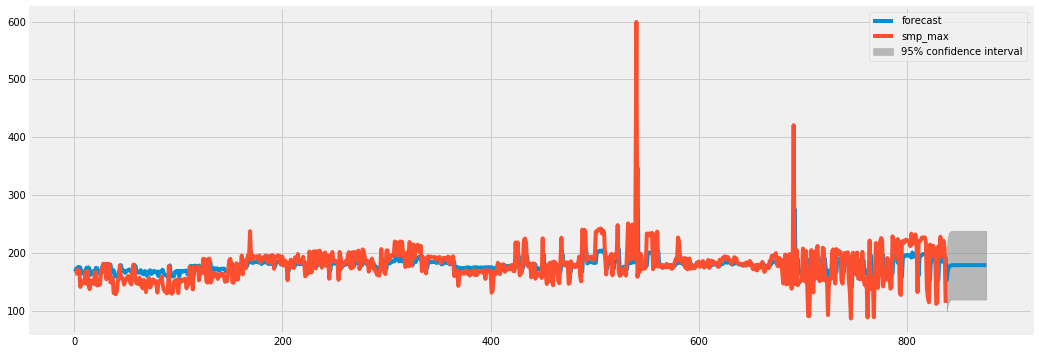

In [138]:
# Predicting humidity level of Montreal
supply = ARMA(data.smp_max, order=(1,0))
res = supply.fit()
res.plot_predict(start=1, end=876)
plt.show()

In [139]:
rmse = math.sqrt(mean_squared_error(data.smp_max, res.predict(start=1,end=838)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 18.229777101552852.


### MA models¶
The moving-average (MA) model is a common approach for modeling univariate time series. The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

### Simulating MA(1) model

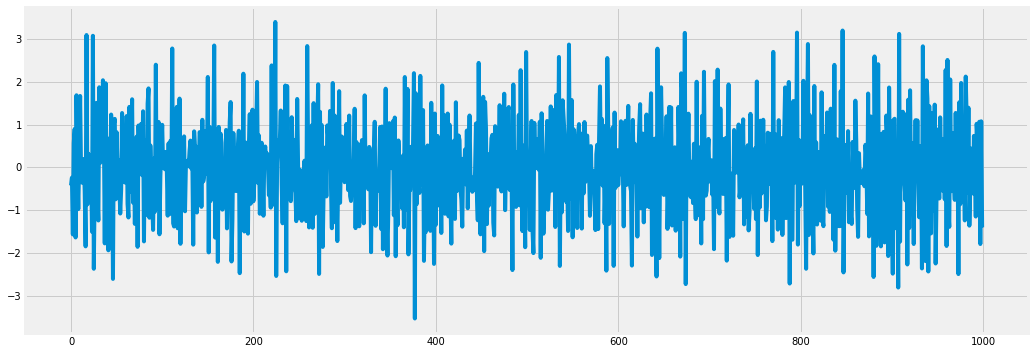

In [42]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

### Forecasting the simulated MA model

In [43]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Tue, 19 May 2020   AIC                           2852.553
Time:                        18:41:02   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

### Prediction using MA models

                              ARMA Model Results                              
Dep. Variable:                smp_max   No. Observations:                  838
Model:                     ARMA(1, 0)   Log Likelihood               -3977.664
Method:                       css-mle   S.D. of innovations             27.871
Date:                Tue, 19 May 2020   AIC                           7961.328
Time:                        19:08:05   BIC                           7975.521
Sample:                             0   HQIC                          7966.769
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           178.7102      1.604    111.385      0.000     175.566     181.855
ar.L1.smp_max     0.4004      0.032     12.613      0.000       0.338       0.463
                                    Root

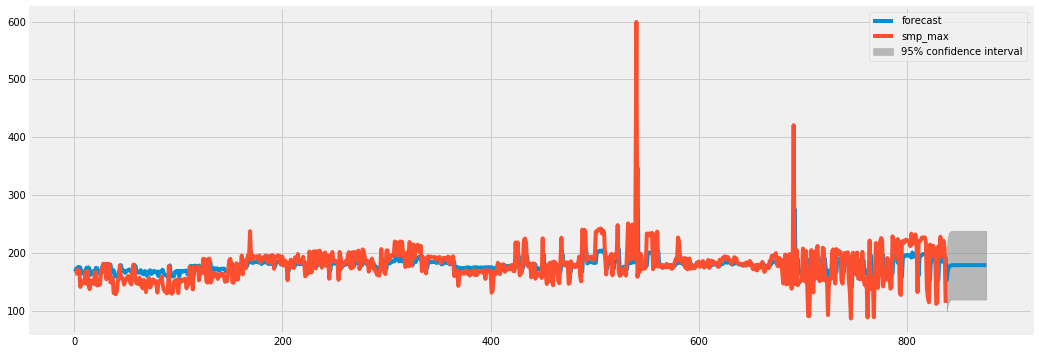

In [140]:
model = ARMA(data.smp_max, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1, end=876)
plt.show()

In [141]:
rmse = math.sqrt(mean_squared_error(data.smp_max, result.predict(start=1,end=838)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 18.229777101552852.


In [142]:
result.predict(start=1,end=872).to_csv("a.csv")

### ARMA models
Autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and the second for the moving average. It's the fusion of AR and MA models.

### Prediction using ARMA models
I am not simulating any model because it's quite similar to AR and MA models. Just forecasting and predictions for this one.

                              ARMA Model Results                              
Dep. Variable:                smp_max   No. Observations:                  838
Model:                     ARMA(3, 3)   Log Likelihood               -3937.037
Method:                       css-mle   S.D. of innovations             26.542
Date:                Tue, 19 May 2020   AIC                           7890.075
Time:                        19:05:53   BIC                           7927.923
Sample:                             0   HQIC                          7904.582
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           178.0970      5.426     32.821      0.000     167.462     188.732
ar.L1.smp_max    -0.1651      0.170     -0.971      0.332      -0.498       0.168
ar.L2.smp_max     0.9456      0.041     

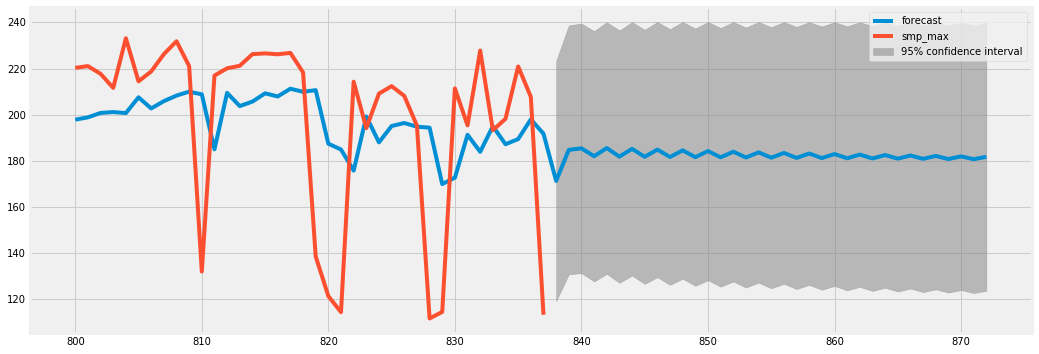

In [130]:
model = ARMA(data.smp_max, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=800, end=872)
plt.show()

In [131]:
rmse = math.sqrt(mean_squared_error(data.smp_max, result.predict(start=1,end=838)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 20.119683263403967.


In [106]:
result.predict(start=1,end=872).to_csv("aa.csv")

### ARIMA models
An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

### Prediction using ARIMA model

                             ARIMA Model Results                              
Dep. Variable:              D.smp_max   No. Observations:                  837
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4013.822
Method:                       css-mle   S.D. of innovations             29.263
Date:                Tue, 19 May 2020   AIC                           8035.644
Time:                        19:06:23   BIC                           8054.563
Sample:                             1   HQIC                          8042.896
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0017      0.557      0.003      0.998      -1.091       1.094
ar.L1.D.smp_max    -0.4946      0.033    -15.015      0.000      -0.559      -0.430
ar.L2.D.smp_max    -0.3215      

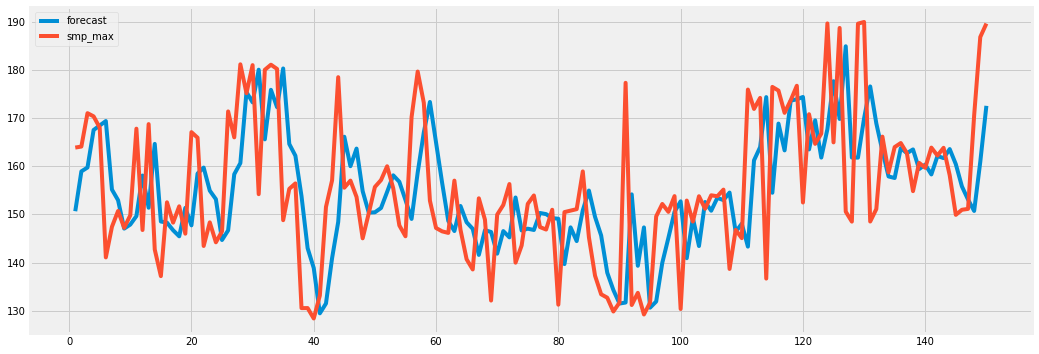

In [132]:
rcParams['figure.figsize'] = 16, 6
model = ARIMA(data.smp_max, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=1, end=150)
plt.show()

In [133]:
rmse = math.sqrt(mean_squared_error(data.smp_max, result.predict(start=2,end=839)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 181.5099598118097.


### VAR models¶
Vector autoregression (VAR) is a stochastic process model used to capture the linear interdependencies among multiple time series. VAR models generalize the univariate autoregressive model (AR model) by allowing for more than one evolving variable. All variables in a VAR enter the model in the same way: each variable has an equation explaining its evolution based on its own lagged values, the lagged values of the other model variables, and an error term. VAR modeling does not require as much knowledge about the forces influencing a variable as do structural models with simultaneous equations: The only prior knowledge required is a list of variables which can be hypothesized to affect each other intertemporally.

C:\Users\lonj7\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



                             Statespace Model Results                            
Dep. Variable:     ['supply', 'smp_max']   No. Observations:                  838
Model:                        VARMA(2,1)   Log Likelihood               -6191.173
                             + intercept   AIC                          12416.345
Date:                   Tue, 19 May 2020   BIC                          12496.773
Time:                           18:43:21   HQIC                         12447.174
Sample:                                0                                         
                                   - 838                                         
Covariance Type:                     opg                                         
Ljung-Box (Q):              266.91, 184.12   Jarque-Bera (JB):     26.96, 126293.93
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.28, 3.36   Skew:                       0.16, 3.99
Prob(H) (t

C:\Users\lonj7\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



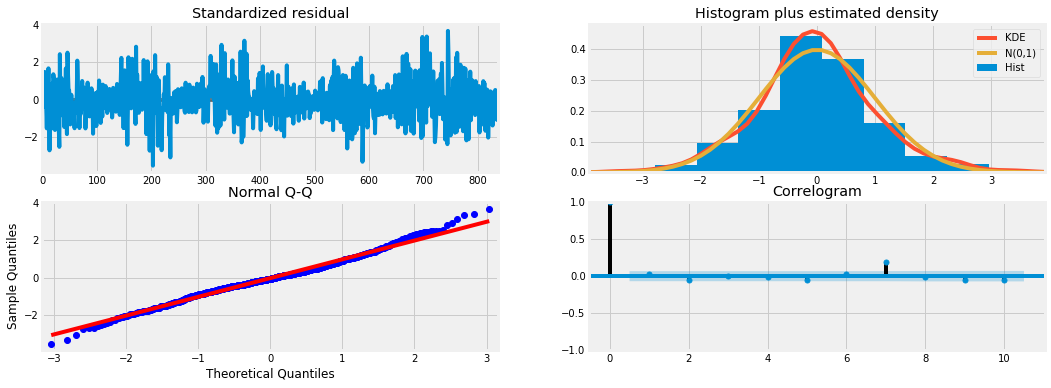

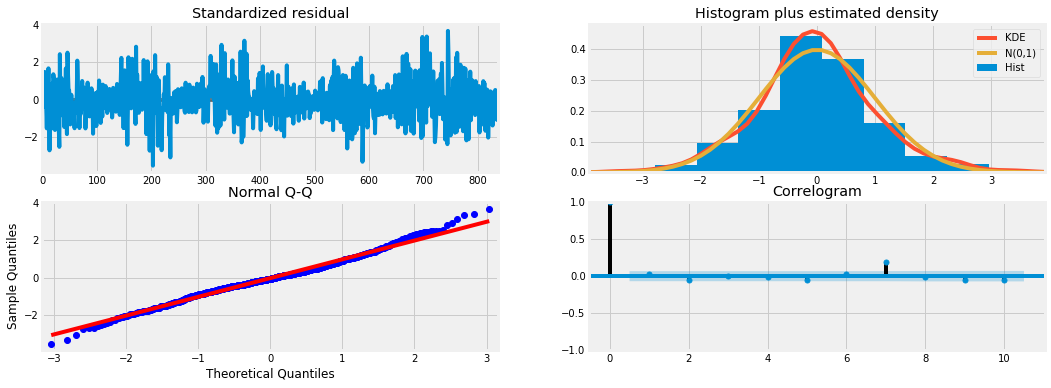

In [65]:
train_sample = pd.concat([data.supply, data.smp_max],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=1, end=838)
result.plot_diagnostics()

In [66]:
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.supply, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

ValueError: y_true and y_pred have different number of output (1!=2)

### SARIMA models¶
SARIMA models are useful for modeling seasonal time series, in which the mean and other statistics for a given season are not stationary across the years. The SARIMA model defined constitutes a straightforward extension of the nonseasonal autoregressive-moving average (ARMA) and autoregressive integrated moving average (ARIMA) models presented

                               SARIMAX Results                                
Dep. Variable:                smp_max   No. Observations:                  838
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -3932.794
Date:                Tue, 19 May 2020   AIC                           7885.587
Time:                        19:07:02   BIC                           7932.898
Sample:                             0   HQIC                          7903.722
                                - 838                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.5856     10.359      1.408      0.159      -5.718      34.889
ar.L1         -0.9563      0.183     -5.229      0.000      -1.315      -0.598
ar.L2          0.6941      0.150      4.642      0.0

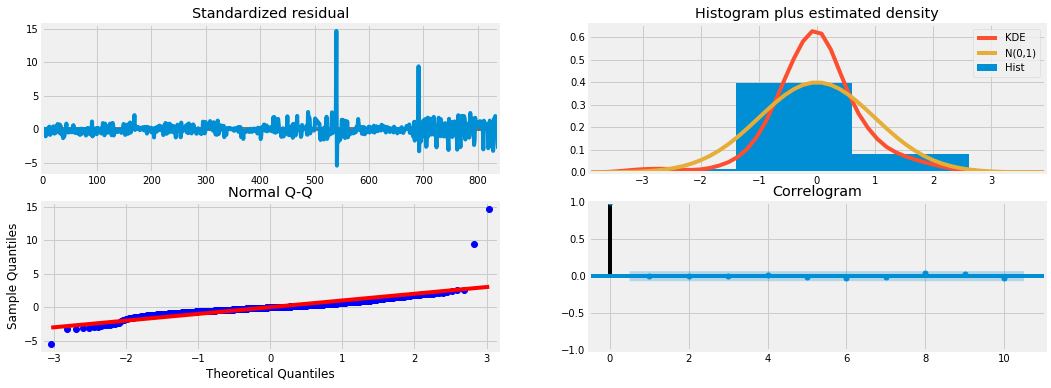

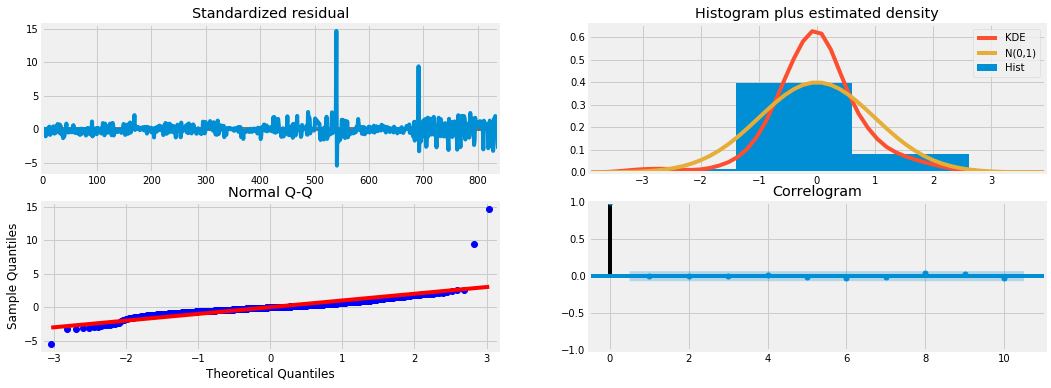

In [134]:
train_sample = data.smp_max
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=1, end=838)
result.plot_diagnostics()

In [135]:
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample, predicted_result))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 20.319238487956387.


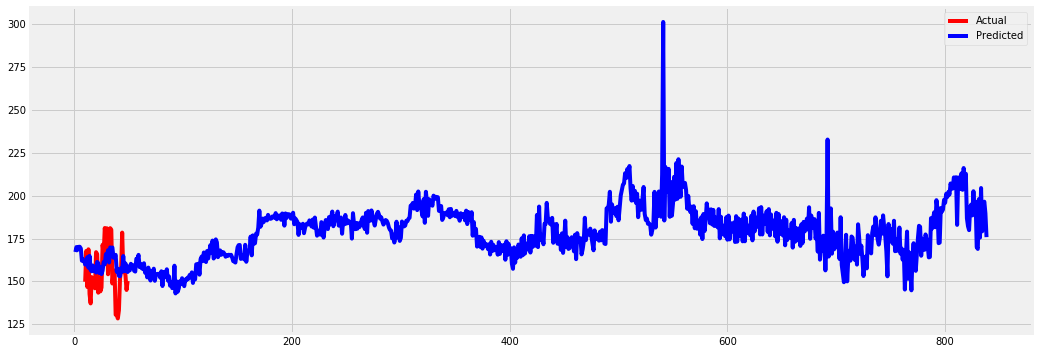

In [136]:
plt.plot(train_sample[10:50],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.show()

### Unobserved components
A UCM decomposes the response series into components such as trend, seasons, cycles, and the regression effects due to predictor series. The following model shows a possible scenario

                        Unobserved Components Results                         
Dep. Variable:                 supply   No. Observations:                  838
Model:                    local level   Log Likelihood               -2277.347
Date:                Tue, 19 May 2020   AIC                           4558.693
Time:                        18:44:40   BIC                           4568.153
Sample:                             0   HQIC                          4562.319
                                - 838                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     1.3313      0.408      3.260      0.001       0.531       2.132
sigma2.level        10.9834      0.883     12.437      0.000       9.253      12.714
Ljung-Box (Q):              

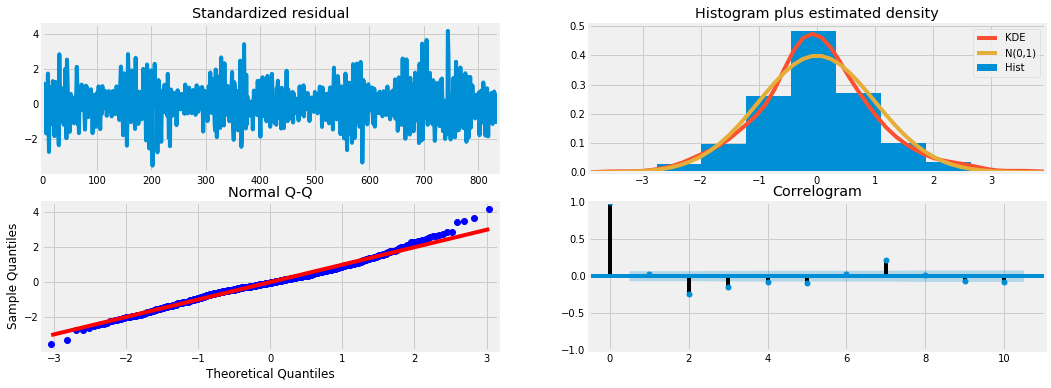

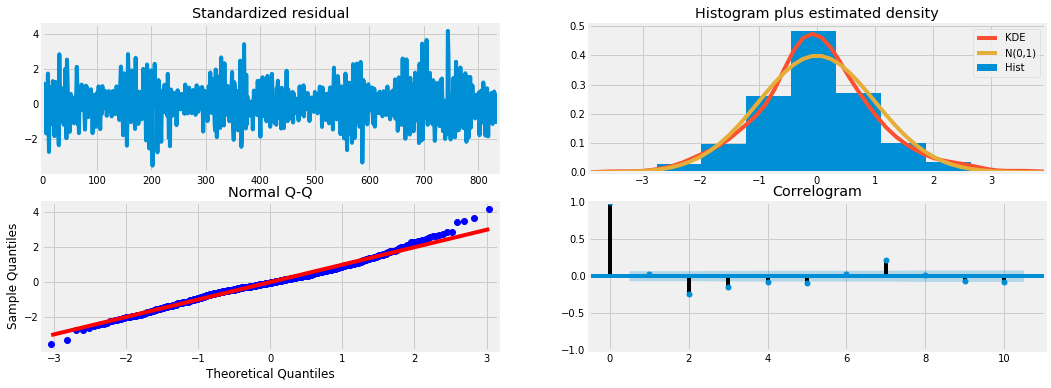

In [74]:
train_sample = data.supply
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=1, end=838)
result.plot_diagnostics()

In [79]:
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[0, 836], predicted_result))
print("The root mean squared error is {}.".format(rmse))

KeyError: (0, 836)

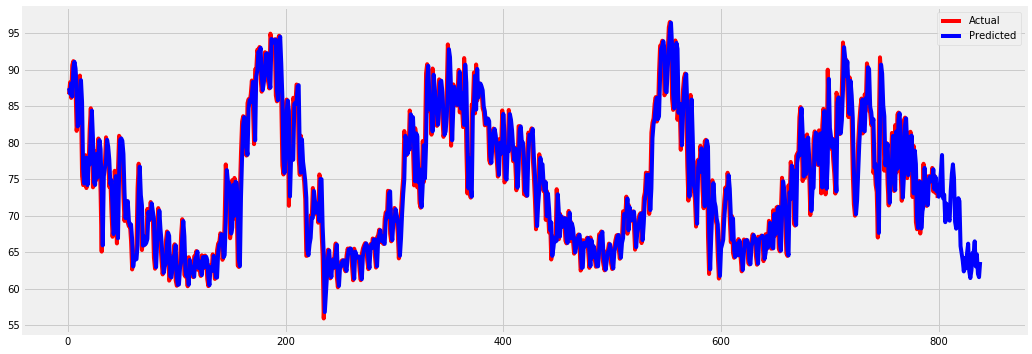

In [78]:
plt.plot(train_sample[1:800],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.show()

### Dynamic Factor models
Dynamic-factor models are flexible models for multivariate time series in which the observed endogenous variables are linear functions of exogenous covariates and unobserved factors, which have a vector autoregressive structure. The unobserved factors may also be a function of exogenous covariates. The disturbances in the equations for the dependent variables may be autocorrelated.

                                   Statespace Model Results                                  
Dep. Variable:                 ['supply', 'smp_max']   No. Observations:                  838
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood               -6563.216
Date:                               Tue, 19 May 2020   AIC                          13138.432
Time:                                       18:45:39   BIC                          13166.818
Sample:                                            0   HQIC                         13149.312
                                               - 838                                         
Covariance Type:                                 opg                                         
Ljung-Box (Q):             676.67, 3067.61   Jarque-Bera (JB):      32.88, 18207.68
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.28, 2.00   Skew:                       0.22, 2

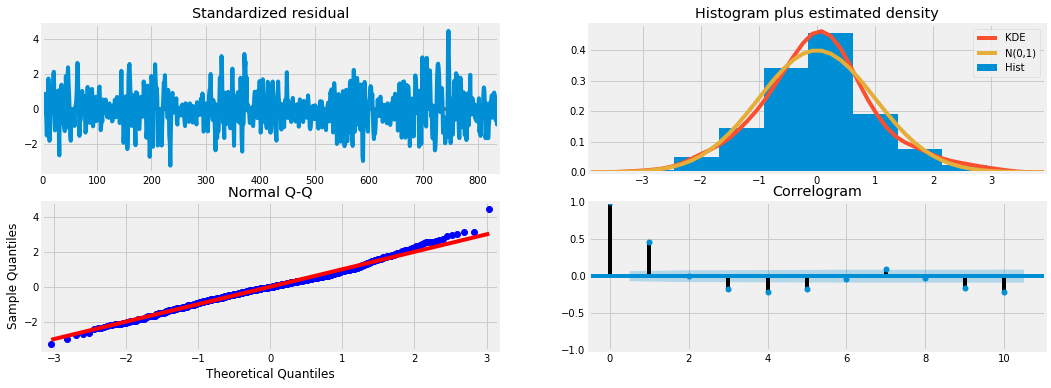

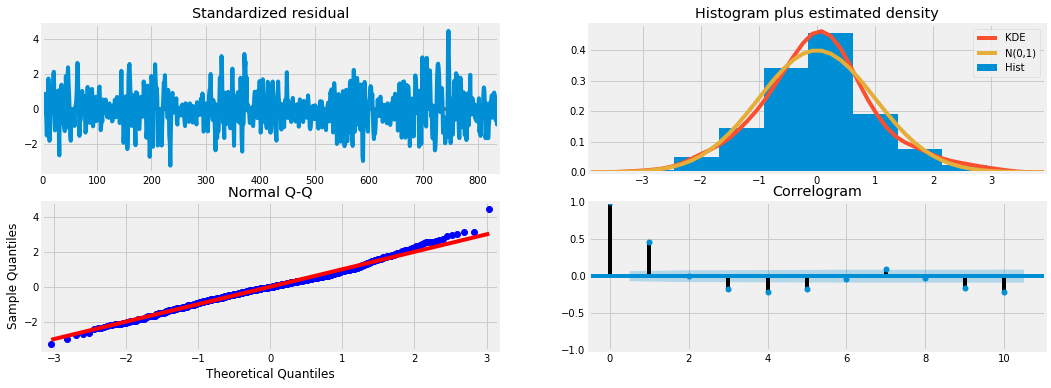

In [81]:
train_sample = pd.concat([data.supply, data.smp_max],axis=1)
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=800,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=800)
result.plot_diagnostics()

In [83]:

# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:838].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

ValueError: Found input variables with inconsistent numbers of samples: [837, 801]

https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

LSTM